<h1>Final Project - COVID:Income Linkage</h1>
by Gulzar Daya

<strong> Project Questions </strong>

<i>Question 1:Describes the project. If you are doing a predefined project choice, explain how you implemented that specific choice. This description should match what you submitted as your project proposal. (4 points)</i>

Answer: This project looks to explore whether a relationship/linkage exists between income by zip code for the City of Chicago and testing, cases, and deaths in reference to the current pandemic, COVID-19.  I am performing two regression analyses on data points available from the City of Chicago and U.S. Census Bureau(ACS(American Community Survey of 2018)).

<i>Question 2:Explains in a few sentences why you selected this project, and if you learned what you had hoped to learn by doing this project (from your proposal). Explain. (4 points)</i>

Answer: I chose this project because of current healthcare concerns with the on-going pandemic. I hypothesized that those persons in higher income areas would be able to test at a higher rate (because of access to testing, better healthcare, more disposable income/savings) and also show lower death statistics.   I was curious to ascertain whether cases in higher income areas of the City of Chicago would also increase but deaths would be lower as those with more disposable income and access to healthcare would be able to quarantine and seek support services more successfully than those who were in socio-economically deprived communities.  I searched through the City of Chicago and U.S. Census Bureaus datasets to test my hypothesis as both have data that is open and free to public.  

<i>Question 3:What you would do differently if you were to have an opportunity to redo this project and why. (4 points)</i>

Answer: Explore other non-linear models, such as clustering.  However, there is not enough data points to do a neural network (or other advanced clustering networks) which I am not familiar with, as of yet.  Ideally, I would have searched and found median income rather than average income (which can be skewed) for various zip codes in City of Chicago.  

<i> Question 4: How to run your project. (4 points) </i>

Answer: <strong>Readme</strong>
- Open Jupyter Notebook.
- Select Kernel/Restart & Run all. Note that the first two notebook cells only contain function definitions and donot display any output
 - User input will be required below Jupyter Notebook Cell 3 to specify which regression to be run for which covid statistic (e.g. cases/tests/deaths) and date
 - Cell 4 has the multi-variate analysis. Sometimes this doesnt execute properly if the Cells 1 and 2 (which has the function definitions) have not been run previously
- Scatter chart and Regression results will show once user has made selections

<i> Question 5: Was the project challenging in the way you expected? What did you overcome? (4 points)</i>

Answer: This project showed me that good data was very hard to get, especially clean data. Different sources used different ways of using data so I was unable to connect the data to line up for analysis. Cleaning up data, such as income had to be manually compiled from U.S. Census Bureau which had data by zip code for the entirety of the USA. I spent a significant portion of my time looking for data, dealing with missing entries, and cleaning up the data.  It took multiple days to clean up and line up data from US Census Bureau in a manner that could be analysized manually.  I spent the majority of my free time learning and understanding how to code and then even longer fixing errors in code.   

<i> Question 6: Cited sources, appropriate acknowledgements. Explain how each source applied to your project. (5 points)</i>

Answer: 
<li>Source of income data is from U.S. Census Bureau, specifically the ACS(American Community Survey of 2018).  
The link is to the raw file that I used from <a href='https://api.census.gov/data/2018/acs/acs5?get=NAME,group(B06011)&for=zip%20code%20tabulation%20area:*'>census.gov</a>. It can be found in project zip file/folder: <i>Chicago_Income.csv</i>.</li>
<li> COVID data is from the <a href='https://data.cityofchicago.org/api/views/yhhz-zm2v/rows.csv?accessType=DOWNLOAD'>City of Chicago website</a>. It can be found in project zip file/folder: <i>COVID-19_Cases_Tests_and_Deaths_by_Zip_Code.csv </i></li>
<li> <i>Note:</i> This is also coded for users to be able to automatically updated directly from City of Chicago website</li>
    <li>  In reference to <i>libraries</i> utilized in this project: Please refer to the comments before each import statement in cells above</li>
    <li>Regression Analysis: I used the following <a href='https://datatofish.com/multiple-linear-regression-python/'>link</a> as a template for bivariate and multivariate regression</li>
    <li> There is some additional individual references which I used for fixing issues/bugs which are cited/linked in the code directly. </li>

<strong>Section 1: COVID FILE IMPORT FUNCTIONS</strong>
- This 1st notebook cell only has function definitions. user needs to run main regression section (3rd cell)
- It is used to read the COVID-19_Cases_Tests_and_Deaths_by_Zip_Code.csv file which will load our dependent variables (i.e. Cases/Tests/Deaths)

In [1]:
import csv
#used to to check if file exists
import os.path 
#used to download file
import urllib.request
#used to convert date strings into date objects for comparison
import datetime as dt

def is_number(string):
    #function is used to check if string is a number. use this instead of isnumeric as that doesnt work for floats
    #https://elearning.wsldp.com/python3/python-check-string-is-a-number/#:~:text=Check%20if%20a%20string%20is%20a%20Float%20in%20Python%203&text=isnumeric()%20function%20will%20return%20False%20for%20the%20floating%20point,floating%20point%20number%20or%20not.&text=As%20per%20the%20above%20python,new%20function%20called%20is_number().
    try:
        float(string)
        return True
    except ValueError:
        return False
    
def download_covid_file(file_name = "COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv"):
    #function downloads the covid file from the website and puts it in the project folder with the right file name
    #https://stackabuse.com/download-files-with-python/
    print('Trying to download file...')
    url = 'https://data.cityofchicago.org/api/views/yhhz-zm2v/rows.csv?accessType=DOWNLOAD'
    #download file from url and save it using new name (file_name)
    urllib.request.urlretrieve(url, file_name)
    return True

def read_covid_file(file_name = "COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv"):
    #Function reads the csv file and extracts the rows (which are organized by zipcode and date) into dictionaries in 3 levels
    #top level dictionary (result) contains file information like headers, rowcount etc.) and the selected columns we want to analyze
    #each selected column is separated into its own date dictionary which has dates corresponding to data collection as keys to another secondary zipcode dictionary
    #secondary zipcode dictionary has the underlying zipcode data for that column and date
    
    #enables extra logging if set to True
    detailed_output = False
    #top level dictionary with entire results
    result = {
      "valid_headers": False,
      "row_count": 0
    }
    with open(file_name) as covid_file:
        csv_reader = csv.reader(covid_file, delimiter=',')
        line_count = 0
        column_mappings = {}
        required_columns = ["ZIP Code", "Week End", 'Cases - Cumulative', 'Case Rate - Cumulative', 'Tests - Cumulative', 'Test Rate - Cumulative', 'Deaths - Cumulative', 'Death Rate - Cumulative']
        for row in csv_reader:
            if line_count == 0:
                column_headers = row
                if detailed_output: print(column_headers)
                #remove special characters in beginning of file
                column_headers[0] = column_headers[0].replace("ï»¿", "")
                #check column_headers to find columns we want
                column_number = 0
                for column_name in column_headers:
                    if column_name in required_columns:
                        #keeping track of the column numbers for the required columns
                        column_mappings[column_name] = column_number
                        #this will have the data for the column
                        
                        # we dont create dictionaries for Week End or Zipcode because it is going to be contained in the heirarchy inside each of the other columns
                        #for example Cases - Cumulative will have a dictionary (value) for every date(Week End; key) which will contain another dictionary with zipcode(key): cases cumulative(value)
                        if column_name not in ["Week End", "ZIP Code"]: result[column_name] = {}
                    column_number += 1
                    
                result["column_mapping"] = column_mappings
                #print("column_mappings", column_mappings)
                if detailed_output: print(f'Column names are {", ".join(row)}') 
                
                #check if all 4 required columns are available for analysis
                #this will help if the column order is changed by the illinois dept of health
                if len(column_mappings) != len(required_columns):
                    print("Missing Required Columns. Please check COVID file")
                    return result
                else:
                    result["valid_headers"] = True
                    result["columns"] = column_headers
                line_count += 1
            else:
                #print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
                line_count += 1
                row_dict = {}
                
                #row_week_end_date = dt.datetime.strptime(row[column_mappings["Week End"]], '%m/%d/%Y') 
                #parsing the date and putting it back in string will standardize the format. it will change 11/7/2020 to 11/07/2020
                #row_week_end_date = row_week_end_date.strftime("%m/%d/%Y")
                
                row_week_end_date = row[column_mappings["Week End"]]
                #print("row_week_end_date", row_week_end_date)
                row_zipcode = row[column_mappings["ZIP Code"]]
                
                for required_field in required_columns:
                    #skip the two foundational columns as they apply to the other columns
                    if required_field in ["ZIP Code", "Week End"]: continue
                    # we need to check if the cell has a valid numeric value
                    if is_number(row[column_mappings[required_field]].replace(",", "")):
                        row_cumulative_value = float(row[column_mappings[required_field]].replace(",", ""))
                    else:
                        #we dont have data for this field for this date and zipcode
                        row_cumulative_value = None

                    if row_week_end_date not in result[required_field].keys():
                        #if we dont have a dictionary for the date we need to create it first
                        result[required_field][row_week_end_date] = {}
                    #now add to the dictionary for the date only if it has a value. None values are irrelevant for regression as we wont use those datapoints
                    if row_cumulative_value != None: result[required_field][row_week_end_date][row_zipcode] = row_cumulative_value
                
                #row_tests_cumulative = row[column_mappings["Tests - Cumulative"]]
                #row_deaths_cumulative = row[column_mappings["Deaths - Cumulative"]]

                                
                #result["rows"][line_count - 1] = row 
                
        result["row_count"] = line_count
        print(f'Processed {line_count} lines.')
    return result

def read_covid_file_from_user():
    #function takes input from user if covid file is missing or invalid to find location of correct file 
    #we call this function from the regression sections
    covid_file_read = False
    curr_filename = "COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv"

    while covid_file_read == False:
        # we keep looping until we get a valid covid file 
        if os.path.isfile(curr_filename): 
            print("Covid Data File found!") 
            #try to read file
            covid_file_data = read_covid_file(curr_filename)
            print ("----File details:")
            #check if file contents are valid
            if covid_file_data['valid_headers'] != True:
                print("Invalid Headers in file. Please ensure that File is valid.")
                #if column headers dont match then ask user for path again to get correct file so that we can try again
                curr_filename = input("Please enter correct filename for COVID file>")
                continue
            if covid_file_data["row_count"] == 0:
                print("No rows found in Covid File. Please ensure that File is valid.")
                #if no rows found then ask user for path again to get correct file so that we can try again
                curr_filename = input("Please enter correct filename for COVID file>")
                continue
            # everything is okay with the file so we can exit the loop 
            for result_key in covid_file_data.keys():
                if type(covid_file_data[result_key]) is dict:
                    print(result_key, "available for", len(covid_file_data[result_key]), "dates") 
                else:
                    print(result_key, covid_file_data[result_key]) 
            #print(result["Deaths - Cumulative"])

            covid_file_read = True
        else:
            #cant find file ask user for filename
            curr_filename = input("Please enter correct filename for COVID file>")
        
        return covid_file_data

#Main Block for testing
if 1 == 0 :
    fn_output = read_covid_file_from_user()
    print(fn_output["Death Rate - Cumulative"].keys())
    print("column_mapping", fn_output["column_mapping"])
    
    for x in fn_output["column_mapping"].keys():
        if x in ["ZIP Code", "Week End"]: continue
        print("----------")
        print(x, fn_output[x]['11/07/2020'], f"count={len(fn_output[x]['11/07/2020'])}")

#References:
#    https://data.cityofchicago.org/api/views/yhhz-zm2v/rows.csv?accessType=DOWNLOAD

<strong>Section 2: INCOME FILE IMPORT FUNCTIONS</strong>
 - This 2nd notebook cell only has function definitions. The user needs to run main regression section (Third cell)

In [2]:
def read_income_file(file_name = "Chicago_Income.csv"):
    #function reads the income file in the project folder and parses it into the result dictionary
    #enables extra logging if set to True
    detailed_output = False
    result = {
      "valid_headers": False,
      "row_count": 0,
      "Income": {}
    }
    with open(file_name) as income_file:
        #read the csv format file into the variable
        csv_reader = csv.reader(income_file, delimiter=',')
        line_count = 0
        column_mappings = {}
        required_columns = ["ZIP Code", "Income"]
        for row in csv_reader:
            if line_count == 0:
                column_headers = row
                if detailed_output: print(column_headers)
                #remove special characters in beginning of file (if utf8)
                column_headers[0] = column_headers[0].replace("ï»¿", "")
                #print("column_mappings", column_mappings)
                if detailed_output: print(f'Column names are {", ".join(row)}') 
                
                #check if all 4 required columns are available for analysis
                #this will help if the column order is changed by the illinois dept of health
                if (column_headers[0] == "ZIP Code") and (column_headers[1] == "Income"):
                    result["valid_headers"] = True
                    result["columns"] = column_headers
                else:
                    print("Missing Required Columns. Please check Chicago Income file")
                    return result
                line_count += 1
            else:
                #print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
                line_count += 1
                if is_number(row[1]):
                    result["Income"][row[0]] = float(row[1])
                else:
                    #skip if missing income for zipcode
                    continue
                
        result["row_count"] = line_count
        print(f'Processed {line_count} lines.')
    return result

#main block for testing
#income_file_data = read_income_file()
#print('Income File - Details', income_file_data)

<strong>Section 3: BIVARIATE REGRESSION ANALYSIS</strong>

This section draws scatter plots for the Key Columns (Cumulative Tests/Cases/Deaths) vs Income
User can can select first which column from the covid file and which date they want to see the scatter plot for

- Ensure that the first section has been loaded properly before running this (ie. covid file must be successfully read from above)
- Ensure that the second section has been loaded properly before running this (ie. income file must be successfully read from above)


Do you wish to download the latest covid data file from the City of Chicago website? (yes/no)yes
Trying to download file...
Covid Data File found!
Processed 2221 lines.
----File details:
valid_headers True
row_count 2221
Cases - Cumulative available for 37 dates
Case Rate - Cumulative available for 37 dates
Tests - Cumulative available for 37 dates
Test Rate - Cumulative available for 37 dates
Deaths - Cumulative available for 37 dates
Death Rate - Cumulative available for 37 dates
column_mapping available for 8 dates
columns ['ZIP Code', 'Week Number', 'Week Start', 'Week End', 'Cases - Weekly', 'Cases - Cumulative', 'Case Rate - Weekly', 'Case Rate - Cumulative', 'Tests - Weekly', 'Tests - Cumulative', 'Test Rate - Weekly', 'Test Rate - Cumulative', 'Percent Tested Positive - Weekly', 'Percent Tested Positive - Cumulative', 'Deaths - Weekly', 'Deaths - Cumulative', 'Death Rate - Weekly', 'Death Rate - Cumulative', 'Population', 'Row ID', 'ZIP Code Location']
-------------------------

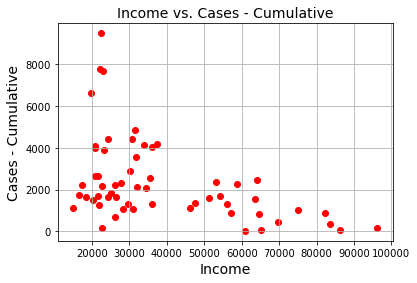

                            OLS Regression Results                            
Dep. Variable:     Cases - Cumulative   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     15.26
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           0.000255
Time:                        13:39:10   Log-Likelihood:                -514.97
No. Observations:                  58   AIC:                             1034.
Df Residuals:                      56   BIC:                             1038.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4074.1577    495.052      8.230      0.0

In [3]:
#pandas dataframe will be like our excel worksheet
import pandas as pd
#pyplot will help us plot the scatter chart so what we can eyeball a potential relationship
import matplotlib.pyplot as plt
#this is used to get the detailed OLS regression analysis
import statsmodels.api as sm
#time is used for a delay which fixes issue when sometimes input shows up before previous print statements
import time
#used to convert date strings into date objects for comparison
import datetime as dt

detailed_logging = False
#first we ask if user wants to download latest file
do_download = input("Do you wish to download the latest covid data file from the City of Chicago website? (yes/no)")
if do_download == "yes":
    download_covid_file()

#we call the covid file read function from the 1st notebook cell
covid_file_data = read_covid_file_from_user()

#we sleep before the first input statement to fix occasional issue of input appearing before previous print statement
#https://stackoverflow.com/questions/50439035/jupyter-notebook-input-line-executed-before-print-statement
print("--------------------------")
time.sleep(1)
#dependent_y_variable = "Deaths - Cumulative"
print("[Option Number] Available Fields (Dependent Variable for Regression: Y-axis)")
available_options = {1: 'Cases - Cumulative', 2: 'Case Rate - Cumulative', 3: 'Tests - Cumulative', 4: 'Test Rate - Cumulative', 5: 'Deaths - Cumulative', 6: 'Death Rate - Cumulative'}
#available_options = {1: "Cases - Cumulative",2: "Tests - Cumulative",3: "Deaths - Cumulative"}
for option in available_options.keys():
    print(f"[{option}] {available_options[option]}")
selected_field_number = 0
while selected_field_number not in available_options.keys():
    selected_field_str = input("Select data point (using option number) from available options >")
    if selected_field_str.isnumeric(): selected_field_number = int(selected_field_str)
dependent_y_variable = available_options[selected_field_number]
print("dependent_y_variable: ", dependent_y_variable)
if detailed_logging: print("dependent_y_variable keys", covid_file_data[dependent_y_variable])
    
#selected_date = "10/31/2020"
print("--------------------------")
print("[Option Number] Available Dates(Takes cumulative data upto Week Ending that date)")
available_date_options = {}
counter = 1
#https://www.geeksforgeeks.org/python-sort-list-of-dates-given-as-strings/
date_str = list(covid_file_data[dependent_y_variable].keys())
date_str.sort(key = lambda date: dt.datetime.strptime(date, '%m/%d/%Y'), reverse=True)     
for week_end_date in date_str:
    available_date_options[counter] = week_end_date
    # we have a lot of dates so we want to show date options in groups of 4
    #https://www.geeksforgeeks.org/print-without-newline-python/
    if counter % 4  == 0:
        #after every fourth date start a new line
        ending_space = "\n"
    else:
        #otherwise tab space the dates by a tab
        ending_space = "\t"
    print(f"[{counter}] {available_date_options[counter]}", end = ending_space)
    counter += 1

#get user selection from the above list of dates
selected_week_date_number = None
while selected_week_date_number not in available_date_options.keys():
    selected_date_str = input("Select date (using option number; 1 is latest) from above >")
    if selected_date_str.isnumeric(): selected_week_date_number = int(selected_date_str)
selected_date = available_date_options[selected_week_date_number]
print("Selected date: ", selected_date)

income_file_data = read_income_file()
independent_x_variable = "Income"


covid_dict = {dependent_y_variable: [], independent_x_variable: []}
for zipcode in covid_file_data[dependent_y_variable][selected_date].keys():
    first_value = covid_file_data[dependent_y_variable][selected_date][zipcode]
    #print("first_value", first_value)
    # we need to ensure that we only add those entries for which we have both values
    #this is done ensuring we match by zipcode
    if independent_x_variable == "Income":
        if zipcode in income_file_data[independent_x_variable]:
            second_value = income_file_data[independent_x_variable][zipcode]
            covid_dict[dependent_y_variable].append(first_value)
            covid_dict[independent_x_variable].append(second_value)
    else:
        #we load the independent variable from the covid data (e.g. cumulative tests/death)
        #only do this if we want to run regressions between two columns from the covid data file
        if zipcode in covid_file_data[independent_x_variable][selected_date]:
            second_value = covid_file_data[independent_x_variable][selected_date][zipcode]
            covid_dict[dependent_y_variable].append(first_value)
            covid_dict[independent_x_variable].append(second_value)

    #dependent_y_variable: list(covid_file_data[dependent_y_variable][selected_date].values()),
    #independent_x_variable: list(covid_file_data[independent_x_variable][selected_date].values())

if detailed_logging: print(covid_dict)
#create the pandas dataframe from the dictionary with the correct column names
df = pd.DataFrame(covid_dict, columns=[independent_x_variable, dependent_y_variable])

#generate a scatter plot for the data so that we can eyeball potential relationships
plt.scatter(df[independent_x_variable], df[dependent_y_variable], color='red')
#format the title 
plt.title(f"{independent_x_variable} vs. {dependent_y_variable}", fontsize=14)
#format the axes
plt.xlabel(independent_x_variable, fontsize=14)
plt.ylabel(dependent_y_variable, fontsize=14)
plt.grid(True)
plt.show()

# Regression with statsmodels
X = df[independent_x_variable] 
Y = df[dependent_y_variable]
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

#print the regression output
print_model = model.summary()
print(print_model)

#REFERENCES:
#https://datatofish.com/multiple-linear-regression-python/


#### Section 4: <strong>MULTIVARIATE REGRESSION ANALYSIS</strong>

<i>Note:</i>if this section is not running properly, make sure cells 1 & 2 have been run prior (so that the import functions are available)

In [4]:
#pandas dataframe will be like our excel worksheet
import pandas as pd
#this is used to get the detailed OLS regression analysis
import statsmodels.api as sm
#time is used for a delay which fixes issue when sometimes input shows up before previous print statements
import time
#used to convert date strings into date objects for comparison
import datetime as dt

detailed_logging = False
#first we ask if user wants to download latest file
do_download = input("Do you wish to download the latest covid data file from the City of Chicago website? (yes/no)")
if do_download == "yes":
    download_covid_file()

#we call the covid file read function from the 1st notebook cell
covid_file_data = read_covid_file_from_user()

#we sleep before the first input statement to fix occasional issue of input appearing before previous print statement
#https://stackoverflow.com/questions/50439035/jupyter-notebook-input-line-executed-before-print-statement
print("--------------------------")
time.sleep(1)
#dependent_y_variable = "Deaths - Cumulative"
print("[Option Number] (Independent Variable Combination for Regression)")
available_options = {1: 'Tests - Cumulative + Income', 2: 'Test Rate - Cumulative + Income'}
for option in available_options.keys():
    print(f"[{option}] {available_options[option]}")
selected_field_number = 0
while selected_field_number not in available_options.keys():
    selected_field_str = input("Select data point (using option number) from available options >")
    if selected_field_str.isnumeric(): selected_field_number = int(selected_field_str)

if selected_field_number == 1:
    additional_independent_x_variable = "Tests - Cumulative"
    independent_x_variable = "Income"
    dependent_y_variable = "Deaths - Cumulative"
else:
    additional_independent_x_variable = "Test Rate - Cumulative"
    independent_x_variable = "Income"
    dependent_y_variable = "Death Rate - Cumulative"
  
#selected_date = "10/31/2020"
print("--------------------------")
print("[Option Number] Available Dates(Takes cumulative data upto Week Ending that date)")
available_date_options = {}
counter = 1
#https://www.geeksforgeeks.org/python-sort-list-of-dates-given-as-strings/
date_str = list(covid_file_data[dependent_y_variable].keys())
date_str.sort(key = lambda date: dt.datetime.strptime(date, '%m/%d/%Y'), reverse=True)     
for week_end_date in date_str:
    available_date_options[counter] = week_end_date
    # we have a lot of dates so we want to show date options in groups of 4
    #https://www.geeksforgeeks.org/print-without-newline-python/
    if counter % 4  == 0:
        #after every fourth date start a new line
        ending_space = "\n"
    else:
        #otherwise tab space the dates by a tab
        ending_space = "\t"
    print(f"[{counter}] {available_date_options[counter]}", end = ending_space)
    counter += 1
    
selected_week_date_number = None
while selected_week_date_number not in available_date_options.keys():
    selected_date_str = input("Select date (using option number; 1 is latest) from above >")
    if selected_date_str.isnumeric(): selected_week_date_number = int(selected_date_str)
selected_date = available_date_options[selected_week_date_number]
#https://www.programiz.com/python-programming/datetime/strftime
#selected_date = selected_date.strftime("%m/%d/%Y")
print("Selected date: ", selected_date)

#this will be replaced by income
#independent_x_variable = "Deaths - Cumulative"

income_file_data = read_income_file()
#independent_x_variable = "Income"

regression_dict = {dependent_y_variable: [], independent_x_variable: [], additional_independent_x_variable: []}

for zipcode in covid_file_data[dependent_y_variable][selected_date].keys():
    #we match up the data for the dependent variable to the  two selected independent variables by zipcode
    dependent_value = covid_file_data[dependent_y_variable][selected_date][zipcode]
    if zipcode in income_file_data[independent_x_variable]:
        independent_value = income_file_data[independent_x_variable][zipcode]
    else:
        independent_value = None
    if zipcode in covid_file_data[additional_independent_x_variable][selected_date]:
        additional_independent_value = covid_file_data[additional_independent_x_variable][selected_date][zipcode]
    else:
        additional_independent_value = None
    
    #if all three values are present we add to regression dictionary
    if independent_value != None and additional_independent_value != None:
        regression_dict[dependent_y_variable].append(dependent_value)
        regression_dict[independent_x_variable].append(independent_value)
        regression_dict[additional_independent_x_variable].append(additional_independent_value)
        
        
if detailed_logging: print(regression_dict)

#put the regression dictionary inside the dataframe with the correct column names
df = pd.DataFrame(regression_dict, columns=[dependent_y_variable, independent_x_variable, additional_independent_x_variable])

# Multivariate Regression with statsmodels
# here we can have 2 variables for multiple regression by adding more fields.
X = df[[independent_x_variable, additional_independent_x_variable]] 
Y = df[dependent_y_variable]
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
#display output for the regression
print_model = model.summary()
print(print_model)

#REFERENCES:
#https://datatofish.com/multiple-linear-regression-python/


Do you wish to download the latest covid data file from the City of Chicago website? (yes/no)no
Covid Data File found!
Processed 2221 lines.
----File details:
valid_headers True
row_count 2221
Cases - Cumulative available for 37 dates
Case Rate - Cumulative available for 37 dates
Tests - Cumulative available for 37 dates
Test Rate - Cumulative available for 37 dates
Deaths - Cumulative available for 37 dates
Death Rate - Cumulative available for 37 dates
column_mapping available for 8 dates
columns ['ZIP Code', 'Week Number', 'Week Start', 'Week End', 'Cases - Weekly', 'Cases - Cumulative', 'Case Rate - Weekly', 'Case Rate - Cumulative', 'Tests - Weekly', 'Tests - Cumulative', 'Test Rate - Weekly', 'Test Rate - Cumulative', 'Percent Tested Positive - Weekly', 'Percent Tested Positive - Cumulative', 'Deaths - Weekly', 'Deaths - Cumulative', 'Death Rate - Weekly', 'Death Rate - Cumulative', 'Population', 'Row ID', 'ZIP Code Location']
--------------------------
[Option Number] (Independe

<strong>Analysis Of Results:</strong>

<p>Two types of regression analysis were performed. </p>

<p>Analysis 1: Bivariate analysis performed between income and various other COVID-19 variables available. 
<li> Independent variable was: Income.  </li>
<li> Dependent variables that can be utilized are: Cases, Case Rates, Tests, Test Rates, Deaths, Death Rates.  </li>
    <li><i>Note:</i> All rates are per 100,000 </li>
<li> Results show very poor results (R^2) in all bivariate analysis.  The strongest R^2, which was between income and death rate shows a poor R^2 (@43%).  
</p>   
<p>Analysis 2: This was a multivariate analysis performed to determine is transforming data yielded higher R^2. 
    <li>Independent variables were: Income + Tests & Income + Rates </li>
    <li>Dependent variables were: Deaths & Death Rates </li>
<li>Overall, multivariate regression showed a marked higher R^2 than bivariate regression. These variables were compared because they made the most sense to compare income and tests against deaths and death rate to see if a strong correlation existed.  This shows that transforming the data may not always be optimal(absolute deaths versus death rate. </li>
</p>